# Network component analysis

In [1]:
import pandas as pd
from pathlib import Path
import networkx as nx
from networkx.algorithms import community
from tqdm import tqdm
import copy
from time import perf_counter
import matplotlib.pyplot as plt
from dotenv import load_dotenv
load_dotenv("./.env.local")
import os
BEARER_TOKEN = os.getenv("BEARER_TOKEN")
import tweepy
client = tweepy.Client(BEARER_TOKEN, wait_on_rate_limit=True)

## Load the data and create NetworkX graphs

In [3]:
edgelists = {}
nx_graphs = {}

for file in Path("edgelistsFull").iterdir():
    tmp_edgelist = pd.read_csv(file)
    edgelists[file.stem] = tmp_edgelist

    tmp_nx_graph = nx.from_pandas_edgelist(tmp_edgelist, source='Source', target='Target', create_using=nx.Graph())
    # Ensure that graphs have a 'weight' edge attribute
    nx.set_edge_attributes(tmp_nx_graph, 1, 'weight')
    nx_graphs[file.stem] = tmp_nx_graph

## Our Louvain implementation

In [4]:
# Louvain implementation
def louvain(G, npassage):
    # Will contain the graph and the communities after each passage
    data = {}
    for i in range(0, npassage):
        print(f"Passage {i+1}", flush=True)
        G, communities, get_community = louvain_step(G, i==0)
        data[i] = get_community
        print(f"There are {len(communities)} communities after passage {i+1}", flush=True)
    return data


def louvain_step(G, is_first_passage):
    # Step 1: Initialization, start with each node being a single community
    communities = {idx: set([node]) for idx, node in enumerate(G.nodes)}
    # To get direct access to the community (it speeds up a bit the algorithm)
    get_community = {node: idx for idx, node in enumerate(G.nodes)}
    # Used in the modularity computation
    neighbors_sets = {node: set(G.neighbors(node)) for node in G.nodes}
    m = len(G.edges)

    # Sum the weights of the incident edges for all nodes inside a community, for all communities
    # Separate first passage and other ones to speed up the algorithm
    if is_first_passage:
        sum_communities = {idx: sum(dict(G.degree(community)).values()) for idx, community in communities.items()}
    else:
        sum_communities = {idx: sum(dict(G.degree(community, 'weight')).values()) for idx, community in communities.items()}

    prev_communities = {}
    i = 0
    # While there are changes in the communities, make another iteration
    while(communities != prev_communities):
        print(f"Iteration {i+1}", flush=True)
        # Deepcopy to have a new object with a new reference
        # Otherwise comparison in while is always True
        prev_communities = copy.deepcopy(communities)
        
        for node in tqdm(G.nodes):
            # Step 2: Remove node from its community
            neighboring_communities = get_neighboring_communities(G, node, get_community)
            if neighboring_communities == set():
                continue
            belong_to = get_community[node]
            communities[belong_to].remove(node)
            sum_communities[belong_to] -= G.degree(node, 'weight')
            if communities[belong_to] == set():
                del communities[belong_to]
                del sum_communities[belong_to]

            # Step 3: Insert the node in the community that maximizes the modularity
            scores = [
                (neighbor_community, modularity_gain(G, node, communities[neighbor_community], sum_communities[neighbor_community], neighbors_sets[node], m, is_first_passage))
                for neighbor_community in neighboring_communities
            ]
            best_community, best_score = max(scores, key=lambda x: x[1])
            communities[best_community].add(node)
            get_community[node] = best_community
            sum_communities[best_community] += G.degree(node, 'weight')
          
        i += 1

    # Step 4: Update the graph
    if is_first_passage:
        return get_new_graph(G, communities, sum_communities, get_community), communities, get_community
    return get_new_graph(G, communities, sum_communities, get_community), communities, get_community


def get_neighboring_communities(G, node, get_community):
    # Use a set to make sure a community only appear once
    neighboring_communities = set()
    for neighbor in G.neighbors(node):
        if neighbor == node: continue
        neighboring_communities.add(get_community[neighbor])
    return neighboring_communities


def modularity_gain(G, node, community, sum_community, neighbor_set, m, is_first_passage):
    # Separate first passage and other ones to speed up the algorithm
    if is_first_passage:
        # Sum the weights of the edges from node into community nodes
        # Using sets allow to use intersection()
        sum_weights_node = len(neighbor_set.intersection(community))
        right_member = (sum_community * G.degree[node]) / (2 * (m**2))
    else:
        # Sum the weights of the edges from node into community nodes
        sum_weights_node = sum([G.get_edge_data(node, member)['weight'] for member in G.neighbors(node) if member in community])
        right_member = (sum_community * G.degree(node, 'weight')) / (2 * (m**2))
    # Compute modularity
    left_member = sum_weights_node / (2 * m)
    return left_member - right_member


def get_new_graph(old_G, communities, sum_communities, get_community):
    print("Constructing new graph", flush=True)
    G = nx.Graph()
    G.add_nodes_from(communities.keys())
    for community in communities:
        G.add_edge(community, community, weight=sum_communities[community])

    for source, dest, weight_dict in old_G.edges(data=True):
        community1 = get_community[source]
        community2 = get_community[dest]
        # If edge not exist, weight initialized at 0
        current_weight = G.get_edge_data(community1, community2, {'weight': 0})['weight']
        new_weight = current_weight + weight_dict['weight']
        G.add_edge(community1, community2, weight=new_weight)
    return G

## Run our Louvain on the graphs

In [5]:
results = {}
for name, G in nx_graphs.items():
    print(f"Louvain on {name}")
    data = louvain(G, 2)
    results[name] = data
    print(f"\n")

Louvain on edgelists_any
Passage 1
Iteration 1


100%|██████████| 2790330/2790330 [00:51<00:00, 54604.53it/s]

Iteration 2



100%|██████████| 2790330/2790330 [00:46<00:00, 59730.01it/s]

Iteration 3



100%|██████████| 2790330/2790330 [00:44<00:00, 62137.09it/s]

Iteration 4



100%|██████████| 2790330/2790330 [00:45<00:00, 60797.15it/s]

Iteration 5



100%|██████████| 2790330/2790330 [00:45<00:00, 60739.98it/s]

Iteration 6



100%|██████████| 2790330/2790330 [00:45<00:00, 60767.75it/s]


Iteration 7


100%|██████████| 2790330/2790330 [00:48<00:00, 57249.51it/s]


Iteration 8


100%|██████████| 2790330/2790330 [00:54<00:00, 51613.38it/s]


Constructing new graph
There are 769 communities after passage 1
Passage 2
Iteration 1


100%|██████████| 769/769 [00:01<00:00, 427.70it/s]

Iteration 2



100%|██████████| 769/769 [00:01<00:00, 461.30it/s]

Iteration 3



100%|██████████| 769/769 [00:01<00:00, 556.04it/s]

Iteration 4



100%|██████████| 769/769 [00:01<00:00, 489.19it/s]

Iteration 5



100%|██████████| 769/769 [00:01<00:00, 625.71it/s]

Iteration 6



100%|██████████| 769/769 [00:01<00:00, 732.38it/s]

Iteration 7



100%|██████████| 769/769 [00:01<00:00, 660.65it/s]

Iteration 8



100%|██████████| 769/769 [00:01<00:00, 753.18it/s] 

Iteration 9



100%|██████████| 769/769 [00:00<00:00, 774.42it/s] 

Iteration 10



100%|██████████| 769/769 [00:00<00:00, 978.38it/s] 

Iteration 11



100%|██████████| 769/769 [00:00<00:00, 1060.70it/s]

Iteration 12



100%|██████████| 769/769 [00:00<00:00, 852.55it/s] 

Iteration 13



100%|██████████| 769/769 [00:00<00:00, 1149.48it/s]

Iteration 14



100%|██████████| 769/769 [00:00<00:00, 1385.59it/s]

Iteration 15



100%|██████████| 769/769 [00:00<00:00, 1403.29it/s]

Iteration 16



100%|██████████| 769/769 [00:00<00:00, 1493.20it/s]

Iteration 17



100%|██████████| 769/769 [00:00<00:00, 1504.90it/s]

Iteration 18



100%|██████████| 769/769 [00:00<00:00, 1612.17it/s]

Iteration 19



100%|██████████| 769/769 [00:00<00:00, 1675.38it/s]

Iteration 20



100%|██████████| 769/769 [00:00<00:00, 1701.33it/s]

Iteration 21



100%|██████████| 769/769 [00:00<00:00, 1705.11it/s]

Iteration 22



100%|██████████| 769/769 [00:00<00:00, 1853.01it/s]

Iteration 23



100%|██████████| 769/769 [00:00<00:00, 1835.34it/s]

Iteration 24



100%|██████████| 769/769 [00:00<00:00, 1951.77it/s]

Iteration 25



100%|██████████| 769/769 [00:00<00:00, 1937.03it/s]

Iteration 26



100%|██████████| 769/769 [00:00<00:00, 2034.40it/s]

Iteration 27



100%|██████████| 769/769 [00:00<00:00, 2018.36it/s]

Iteration 28



100%|██████████| 769/769 [00:00<00:00, 2067.23it/s]

Iteration 29



100%|██████████| 769/769 [00:00<00:00, 2124.33it/s]

Iteration 30



100%|██████████| 769/769 [00:00<00:00, 2166.22it/s]

Iteration 31



100%|██████████| 769/769 [00:00<00:00, 2261.77it/s]

Iteration 32



100%|██████████| 769/769 [00:00<00:00, 2302.39it/s]

Iteration 33



100%|██████████| 769/769 [00:00<00:00, 2403.13it/s]

Iteration 34



100%|██████████| 769/769 [00:00<00:00, 2388.22it/s]

Iteration 35



100%|██████████| 769/769 [00:00<00:00, 2456.91it/s]

Iteration 36



100%|██████████| 769/769 [00:00<00:00, 2670.13it/s]

Iteration 37



100%|██████████| 769/769 [00:00<00:00, 2796.39it/s]

Iteration 38



100%|██████████| 769/769 [00:00<00:00, 3003.91it/s]

Iteration 39



100%|██████████| 769/769 [00:00<00:00, 3177.70it/s]

Iteration 40



100%|██████████| 769/769 [00:00<00:00, 3190.88it/s]

Iteration 41



100%|██████████| 769/769 [00:00<00:00, 3527.51it/s]

Iteration 42



100%|██████████| 769/769 [00:00<00:00, 3751.34it/s]

Iteration 43



100%|██████████| 769/769 [00:00<00:00, 3560.73it/s]

Iteration 44



100%|██████████| 769/769 [00:00<00:00, 3432.78it/s]

Iteration 45



100%|██████████| 769/769 [00:00<00:00, 3088.36it/s]

Iteration 46



100%|██████████| 769/769 [00:00<00:00, 3715.01it/s]

Iteration 47



100%|██████████| 769/769 [00:00<00:00, 3300.47it/s]

Iteration 48



100%|██████████| 769/769 [00:00<00:00, 3300.46it/s]

Iteration 49



100%|██████████| 769/769 [00:00<00:00, 3825.89it/s]

Iteration 50



100%|██████████| 769/769 [00:00<00:00, 3864.29it/s]

Iteration 51



100%|██████████| 769/769 [00:00<00:00, 3923.43it/s]

Iteration 52



100%|██████████| 769/769 [00:00<00:00, 3864.35it/s]

Iteration 53



100%|██████████| 769/769 [00:00<00:00, 3864.31it/s]

Iteration 54



100%|██████████| 769/769 [00:00<00:00, 3864.49it/s]

Iteration 55



100%|██████████| 769/769 [00:00<00:00, 3644.53it/s]

Iteration 56



100%|██████████| 769/769 [00:00<00:00, 3751.23it/s]

Iteration 57



100%|██████████| 769/769 [00:00<00:00, 3593.50it/s]

Iteration 58



100%|██████████| 769/769 [00:00<00:00, 3543.78it/s]

Iteration 59



100%|██████████| 769/769 [00:00<00:00, 3479.68it/s]

Iteration 60



100%|██████████| 769/769 [00:00<00:00, 3204.21it/s]

Constructing new graph


There are 124 communities after passage 2


Louvain on edgelists_liking
Passage 1
Iteration 1


100%|██████████| 2668995/2668995 [01:00<00:00, 43811.34it/s]

Iteration 2



100%|██████████| 2668995/2668995 [00:54<00:00, 48683.37it/s]

Iteration 3



100%|██████████| 2668995/2668995 [00:54<00:00, 48857.39it/s]

Iteration 4



100%|██████████| 2668995/2668995 [00:56<00:00, 47531.42it/s]

Iteration 5



100%|██████████| 2668995/2668995 [00:52<00:00, 50974.02it/s]

Iteration 6



100%|██████████| 2668995/2668995 [00:52<00:00, 50552.61it/s]

Iteration 7



100%|██████████| 2668995/2668995 [00:52<00:00, 51324.46it/s]

Iteration 8



100%|██████████| 2668995/2668995 [00:53<00:00, 49859.72it/s]

Iteration 9



100%|██████████| 2668995/2668995 [00:55<00:00, 47837.69it/s]

Iteration 10



100%|██████████| 2668995/2668995 [00:53<00:00, 49480.03it/s]

Iteration 11



100%|██████████| 2668995/2668995 [00:55<00:00, 48080.39it/s]


Constructing new graph
There are 742 communities after passage 1
Passage 2
Iteration 1


100%|██████████| 742/742 [00:01<00:00, 395.73it/s]

Iteration 2



100%|██████████| 742/742 [00:01<00:00, 490.09it/s]

Iteration 3



100%|██████████| 742/742 [00:01<00:00, 565.98it/s]

Iteration 4



100%|██████████| 742/742 [00:01<00:00, 559.16it/s]

Iteration 5



100%|██████████| 742/742 [00:01<00:00, 649.74it/s]

Iteration 6



100%|██████████| 742/742 [00:00<00:00, 754.07it/s]

Iteration 7



100%|██████████| 742/742 [00:00<00:00, 816.28it/s] 

Iteration 8



100%|██████████| 742/742 [00:00<00:00, 882.28it/s] 

Iteration 9



100%|██████████| 742/742 [00:00<00:00, 1010.90it/s]

Iteration 10



100%|██████████| 742/742 [00:00<00:00, 1015.05it/s]

Iteration 11



100%|██████████| 742/742 [00:00<00:00, 1030.56it/s]

Iteration 12



100%|██████████| 742/742 [00:00<00:00, 1073.81it/s]

Iteration 13



100%|██████████| 742/742 [00:00<00:00, 1119.16it/s]

Iteration 14



100%|██████████| 742/742 [00:00<00:00, 1216.39it/s]

Iteration 15



100%|██████████| 742/742 [00:00<00:00, 1236.67it/s]

Iteration 16



100%|██████████| 742/742 [00:00<00:00, 1354.02it/s]

Iteration 17



100%|██████████| 742/742 [00:00<00:00, 1389.53it/s]

Iteration 18



100%|██████████| 742/742 [00:00<00:00, 1336.94it/s]

Iteration 19



100%|██████████| 742/742 [00:00<00:00, 1499.00it/s]

Iteration 20



100%|██████████| 742/742 [00:00<00:00, 1588.88it/s]

Iteration 21



100%|██████████| 742/742 [00:00<00:00, 1520.49it/s]

Iteration 22



100%|██████████| 742/742 [00:00<00:00, 1713.63it/s]

Iteration 23



100%|██████████| 742/742 [00:00<00:00, 1766.67it/s]

Iteration 24



100%|██████████| 742/742 [00:00<00:00, 1761.06it/s]

Iteration 25



100%|██████████| 742/742 [00:00<00:00, 1721.58it/s]

Iteration 26



100%|██████████| 742/742 [00:00<00:00, 1805.37it/s]

Iteration 27



100%|██████████| 742/742 [00:00<00:00, 1701.83it/s]

Iteration 28



100%|██████████| 742/742 [00:00<00:00, 1823.10it/s]

Iteration 29



100%|██████████| 742/742 [00:00<00:00, 1912.36it/s]

Iteration 30



100%|██████████| 742/742 [00:00<00:00, 1957.76it/s]

Iteration 31



100%|██████████| 742/742 [00:00<00:00, 2032.88it/s]

Iteration 32



100%|██████████| 742/742 [00:00<00:00, 1897.69it/s]

Iteration 33



100%|██████████| 742/742 [00:00<00:00, 1873.73it/s]

Iteration 34



100%|██████████| 742/742 [00:00<00:00, 2126.09it/s]

Iteration 35



100%|██████████| 742/742 [00:00<00:00, 1766.66it/s]

Iteration 36



100%|██████████| 742/742 [00:00<00:00, 1917.34it/s]

Iteration 37



100%|██████████| 742/742 [00:00<00:00, 1942.42it/s]

Iteration 38



100%|██████████| 742/742 [00:00<00:00, 1912.37it/s]

Iteration 39



100%|██████████| 742/742 [00:00<00:00, 1989.29it/s]

Iteration 40



100%|██████████| 742/742 [00:00<00:00, 1750.01it/s]

Iteration 41



100%|██████████| 742/742 [00:00<00:00, 1968.18it/s]

Iteration 42



100%|██████████| 742/742 [00:00<00:00, 2016.31it/s]

Iteration 43



100%|██████████| 742/742 [00:00<00:00, 2032.89it/s]

Iteration 44



100%|██████████| 742/742 [00:00<00:00, 1968.17it/s]

Constructing new graph


There are 125 communities after passage 2


Louvain on edgelists_retweeters
Passage 1
Iteration 1


100%|██████████| 520383/520383 [00:10<00:00, 48577.08it/s]

Iteration 2



100%|██████████| 520383/520383 [00:09<00:00, 54765.64it/s]

Iteration 3



100%|██████████| 520383/520383 [00:09<00:00, 55439.45it/s]

Iteration 4



100%|██████████| 520383/520383 [00:09<00:00, 55563.48it/s]

Iteration 5



100%|██████████| 520383/520383 [00:09<00:00, 56099.91it/s]

Iteration 6



100%|██████████| 520383/520383 [00:09<00:00, 53759.58it/s]

Iteration 7



100%|██████████| 520383/520383 [00:10<00:00, 49273.85it/s]

Constructing new graph


There are 660 communities after passage 1
Passage 2
Iteration 1


100%|██████████| 660/660 [00:00<00:00, 664.65it/s]

Iteration 2



100%|██████████| 660/660 [00:00<00:00, 779.22it/s]

Iteration 3



100%|██████████| 660/660 [00:00<00:00, 866.14it/s] 

Iteration 4



100%|██████████| 660/660 [00:00<00:00, 1137.93it/s]

Iteration 5



100%|██████████| 660/660 [00:00<00:00, 1363.64it/s]

Iteration 6



100%|██████████| 660/660 [00:00<00:00, 1327.97it/s]

Iteration 7



100%|██████████| 660/660 [00:00<00:00, 1506.86it/s]

Iteration 8



100%|██████████| 660/660 [00:00<00:00, 1739.47it/s]

Iteration 9



100%|██████████| 660/660 [00:00<00:00, 1896.56it/s]

Iteration 10



100%|██████████| 660/660 [00:00<00:00, 1859.15it/s]

Iteration 11



100%|██████████| 660/660 [00:00<00:00, 2049.69it/s]

Iteration 12



100%|██████████| 660/660 [00:00<00:00, 1935.50it/s]

Iteration 13



100%|██████████| 660/660 [00:00<00:00, 2108.64it/s]

Iteration 14



100%|██████████| 660/660 [00:00<00:00, 2101.95it/s]

Iteration 15



100%|██████████| 660/660 [00:00<00:00, 1875.01it/s]

Iteration 16



100%|██████████| 660/660 [00:00<00:00, 2171.04it/s]

Iteration 17



100%|██████████| 660/660 [00:00<00:00, 2214.77it/s]

Iteration 18



100%|██████████| 660/660 [00:00<00:00, 2252.58it/s]

Iteration 19



100%|██████████| 660/660 [00:00<00:00, 2082.02it/s]

Iteration 20



100%|██████████| 660/660 [00:00<00:00, 2068.98it/s]

Iteration 21



100%|██████████| 660/660 [00:00<00:00, 2283.72it/s]

Iteration 22



100%|██████████| 660/660 [00:00<00:00, 2391.30it/s]

Iteration 23



100%|██████████| 660/660 [00:00<00:00, 2323.99it/s]

Iteration 24



100%|██████████| 660/660 [00:00<00:00, 2260.28it/s]

Iteration 25



100%|██████████| 660/660 [00:00<00:00, 2332.19it/s]

Iteration 26



100%|██████████| 660/660 [00:00<00:00, 2088.59it/s]

Iteration 27



100%|██████████| 660/660 [00:00<00:00, 2268.05it/s]

Iteration 28



100%|██████████| 660/660 [00:00<00:00, 2275.86it/s]

Iteration 29



100%|██████████| 660/660 [00:00<00:00, 2332.16it/s]

Iteration 30



100%|██████████| 660/660 [00:00<00:00, 2365.60it/s]

Iteration 31



100%|██████████| 660/660 [00:00<00:00, 2538.47it/s]

Iteration 32



100%|██████████| 660/660 [00:00<00:00, 2357.15it/s]

Iteration 33



100%|██████████| 660/660 [00:00<00:00, 2444.47it/s]

Iteration 34



100%|██████████| 660/660 [00:00<00:00, 2307.72it/s]

Constructing new graph
There are 167 communities after passage 2




## Export and save label communities of each node (for Gephi)

In [7]:
Path.mkdir(Path("analysis"), exist_ok=True)
Path.mkdir(Path("analysis/communities"), exist_ok=True)

# Get the label communities for the nodes for each passage
for name, result in results.items():
    intermediate_results = []

    for i in range(len(result)-1, -1, -1):
        if i == 0:
            break
        curr = result[i]
        prev = result[i-1]
        intermediate_result =  {node: curr[val] for node, val in prev.items()}
        intermediate_results.append(intermediate_result)
    
    try:
        commu = intermediate_results[-1]
    # If we run only for one passage
    except IndexError:
        commu = result[0]

    communities_df = pd.DataFrame(commu.items(), columns=['Id', 'Community'])
    communities_df["Label"] = communities_df["Id"].map(lambda x: x)
    communities_df["Is_author"] = False

    communities_df.loc[communities_df['Id'].isin(edgelists[name]['Target'].unique()), "Is_author"] = True

    communities_df.to_csv(f"analysis/communities/communities_{name}.csv", index=False)

## Comparing the 3 results

In [8]:
df_results = {
    'any': pd.read_csv("analysis/communities/communities_edgelists_any.csv"),
    'like': pd.read_csv("analysis/communities/communities_edgelists_liking.csv"),
    'retweet': pd.read_csv("analysis/communities/communities_edgelists_retweeters.csv")
}

### Some stats

In [9]:
n = {}
for name, result in df_results.items():
    n[name] = len(result['Id'].unique())
    print(f"Number of nodes in {name}: {n[name]}")

Number of nodes in any: 2790330
Number of nodes in like: 2668995
Number of nodes in retweet: 520383


In [10]:
# Number of nodes for each community
for name, result in df_results.items():
    print(name)
    print(result.groupby('Community')["Id"].count().sort_values(ascending=False))
    print('\n')

any
Community
626    438050
718    373989
225    370657
462    253171
683    243922
        ...  
54          1
715         1
133         1
711         1
768         1
Name: Id, Length: 124, dtype: int64


like
Community
698    427486
614    364996
725    362671
655    159337
409    121251
        ...  
391         1
468         1
479         1
534         1
741         1
Name: Id, Length: 125, dtype: int64


retweet
Community
343    65089
612    62918
378    41742
334    40730
66     26667
       ...  
573        1
470        1
179        1
589        1
590        1
Name: Id, Length: 167, dtype: int64




In [11]:
# Percentage of the total nodes
# Get the three biggest communities
biggest_communities = {}

for name, result in df_results.items():
    print(name)
    df_percent = result.groupby('Community')["Id"].count().sort_values(ascending=False).div(n[name]).mul(100)
    print(df_percent[:15])
    biggest_communities[name] = list(df_percent[:3].index)
    print('\n')

any
Community
626    15.698860
718    13.403038
225    13.283626
462     9.073156
683     8.741690
471     7.156680
758     7.005515
396     6.830733
637     6.767766
216     6.579974
349     5.446703
520     0.001541
253     0.000502
12      0.000430
746     0.000323
Name: Id, dtype: float64


like
Community
698    16.016740
614    13.675410
725    13.588298
655     5.969925
409     4.542946
597     4.540548
577     4.256771
178     2.320461
395     2.314916
681     2.147737
110     2.146763
547     2.077074
365     2.028366
303     1.977898
412     1.903825
Name: Id, dtype: float64


retweet
Community
343    12.507903
612    12.090710
378     8.021400
334     7.826927
66      5.124495
564     5.124111
618     3.199374
272     2.835219
347     2.211832
466     2.170517
376     2.085964
405     1.639369
335     1.528105
390     1.518305
531     1.512155
Name: Id, dtype: float64




### Plots

any


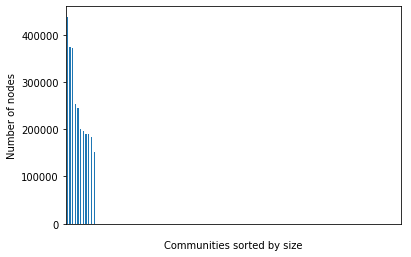

like


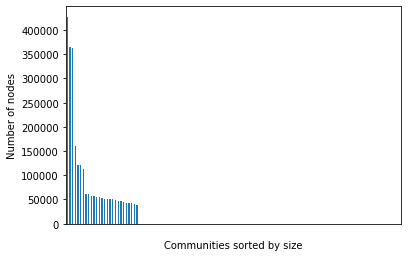

retweet


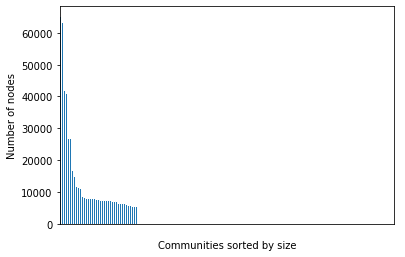

In [12]:
# Bar plot of the number of nodes in each community
for name, result in df_results.items():
    result.groupby('Community')["Id"].count().sort_values(ascending=False).plot(kind='bar')
    plt.xticks(color='w')
    plt.tick_params(bottom=False)
    plt.xlabel("Communities sorted by size", labelpad=-10)
    plt.ylabel("Number of nodes")
    plt.savefig(f"analysis/nodes_in_each_community_{name}.pdf", bbox_inches='tight')
    print(name)
    plt.show()

In [13]:
# Plot the degree distribution
for name, result in df_results.items():
    if name != "any": 
        continue
    gephi_data = pd.read_csv(Path("analysis") / f"gephistats_{name}.csv")
    points = gephi_data.groupby('Degree')["Id"].count().sort_values(ascending=False).div(n['any']).to_frame().reset_index()
    points.plot(x='Degree', y='Id', kind='scatter', logx=True, logy=True, s=3, c='red')
    plt.xlabel("Degree")
    plt.ylabel("Fraction of nodes")
    plt.savefig(f"analysis/degree_distribution_{name}.pdf", bbox_inches='tight')
    print(name)
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'analysis\\gephistats_any.csv'

### Take only the authors from the results

In [14]:
df_results_only_authors = {}
n_unique_only_authors = {}

for name, result in df_results.items():
    df_results_only_authors[name] = result[result['Is_author'] == True]
    n_unique_only_authors[name] = len(df_results_only_authors[name]['Id'].unique())
    print(f"Number of unique authors in {name} only authors: {n_unique_only_authors[name]}")

Number of unique authors in any only authors: 786
Number of unique authors in like only authors: 755
Number of unique authors in retweet only authors: 682


In [15]:
Path.mkdir(Path("analysis/authors"), exist_ok=True)
authors_info = {}

# create a list of all the authors and call the Twitter API
for name, result in df_results_only_authors.items():
    temp_result = result
    authors = list(result["Id"].unique())
    temp_df = pd.DataFrame()
    # split df by 100
    for i in range(0, len(authors), 100):
        print(f"{name}: Iteration {i}-{i+100} / {len(authors)}")
        df_100 = authors[i:i+100]
        res = client.get_users(ids=df_100, user_fields=["public_metrics", "verified"])
        for user_detail in res.data:
            temp_result.loc[temp_result['Id'] == user_detail['id'], 'Username'] = user_detail['username']
            temp_result.loc[temp_result['Id'] == user_detail['id'], 'Verified'] = user_detail['verified']
            temp_result.loc[temp_result['Id'] == user_detail['id'], 'followers_count'] = user_detail['public_metrics']['followers_count']
            temp_result.loc[temp_result['Id'] == user_detail['id'], 'following_count'] = user_detail['public_metrics']['following_count']
            temp_result.loc[temp_result['Id'] == user_detail['id'], 'tweet_count'] = user_detail['public_metrics']['tweet_count']
    temp_df = pd.concat(
        [temp_df, temp_result], ignore_index=True)
    temp_df.to_csv(f"analysis/authors/authors_{name}.csv")
    authors_info[name] = temp_df

any: Iteration 0-100 / 786


Unauthorized: 401 Unauthorized
Unauthorized

### Retrieve authors info for the two biggest communities

#### Any (likes + retweets)

In [10]:
authors_info['any'][authors_info['any']['Community'] == biggest_communities['any'][0]]

,Id,Community,Label,Is_author,Username,Verified,followers_count,following_count,tweet_count
30,300078224,567,300078224,True,MissMeryn,False,314.0,2990.0,7119.0
140,1164907412630827008,567,1164907412630827008,True,NaN,NaN,NaN,NaN,NaN
155,1341232362,567,1341232362,True,valuesearcher,False,218.0,96.0,5618.0
250,1340124668825657349,567,1340124668825657349,True,ARedbord,False,1063.0,494.0,619.0
266,1387847713065213954,567,1387847713065213954,True,masi82870170,False,557.0,1683.0,527.0
317,117213468,567,117213468,True,ArielFornari,False,2505.0,4510.0,194874.0
328,155627025,567,155627025,True,butterflySerend,False,138.0,238.0,15685.0
331,1175962189766643712,567,1175962189766643712,True,ThahirAmal,False,127.0,593.0,3020.0
362,2342054232,567,2342054232,True,KondratieffWave,False,2090.0,4638.0,30047.0
369,1281634934327828482,567,1281634934327828482,True,itayariel1,False,1793.0,726.0,9194.0


In [11]:
authors_info['any'][authors_info['any']['Community'] == biggest_communities['any'][1]]

,Id,Community,Label,Is_author,Username,Verified,followers_count,following_count,tweet_count
9,1461676508808978437,554,1461676508808978437,True,NaN,NaN,NaN,NaN,NaN
16,1405991133017169926,554,1405991133017169926,True,JoeSmols,False,993.0,246.0,15422.0
17,89437990,554,89437990,True,AimHigh_TV1,False,87757.0,6180.0,5958.0
34,393896089,554,393896089,True,olha2810,False,6.0,54.0,312.0
38,4188145335,554,4188145335,True,Sawomir86174818,False,622.0,1841.0,122231.0
41,12166972,554,12166972,True,niniwe,False,261.0,834.0,8865.0
49,729702644,554,729702644,True,BlueDotCitizen,False,6533.0,6574.0,78048.0
73,1456600599940710467,554,1456600599940710467,True,bijouaicha3,False,206.0,199.0,14094.0
74,1390351886704947200,554,1390351886704947200,True,stellarwp,False,1074.0,472.0,1073.0
95,2651414005,554,2651414005,True,Europa97531,False,1702.0,2345.0,47815.0


#### Likes

In [12]:
authors_info['like'][authors_info['like']['Community'] == biggest_communities['like'][0]]

,Id,Community,Label,Is_author,Username,Verified,followers_count,following_count,tweet_count
275,1044937263489134592,183,1044937263489134592,True,stefano688,False,701.0,4948.0,81903.0
283,26651370,183,26651370,True,FrancescoLugli,False,753.0,685.0,10190.0
292,764397613,183,764397613,True,ulrike_baumann,False,259.0,55.0,236.0
519,1341232362,183,1341232362,True,valuesearcher,False,218.0,96.0,5618.0
607,1429797346678874112,183,1429797346678874112,True,Lecca64035164,False,4.0,0.0,1349.0
647,1430307870982107140,183,1430307870982107140,True,CardanoNoodz,False,5937.0,4175.0,23623.0


In [13]:
authors_info['like'][authors_info['like']['Community'] == biggest_communities['like'][1]]

,Id,Community,Label,Is_author,Username,Verified,followers_count,following_count,tweet_count
41,12166972,597,12166972,True,niniwe,False,261.0,834.0,8865.0
72,1390351886704947200,597,1390351886704947200,True,stellarwp,False,1074.0,472.0,1073.0
458,2389823918,597,2389823918,True,AlAkBseth,False,3810.0,3391.0,431448.0


#### Retweet

In [14]:
authors_info['retweet'][authors_info['retweet']['Community'] == biggest_communities['retweet'][0]]

,Id,Community,Label,Is_author,Username,Verified,followers_count,following_count,tweet_count
174,1065202791621296128,614,1065202791621296128,True,urbanhaiti,False,333.0,186.0,5622.0
186,895966977407074304,614,895966977407074304,True,EastMojo,True,17498.0,625.0,40829.0
251,2342054232,614,2342054232,True,KondratieffWave,False,2090.0,4638.0,30047.0
440,1265133839258697728,614,1265133839258697728,True,RR52725843,False,110.0,21.0,7361.0
461,360164560,614,360164560,True,SyriaArchives,False,672.0,2651.0,4955.0
531,26651370,614,26651370,True,FrancescoLugli,False,753.0,685.0,10190.0
533,1496805133279277061,614,1496805133279277061,True,GC35786982,False,2.0,34.0,560.0
534,41014243,614,41014243,True,qvalemangusta,False,1774.0,1226.0,144737.0


In [15]:
authors_info['retweet'][authors_info['retweet']['Community'] == biggest_communities['retweet'][1]]

,Id,Community,Label,Is_author,Username,Verified,followers_count,following_count,tweet_count
116,1340124668825657349,467,1340124668825657349,True,ARedbord,False,1063.0,494.0,619.0
276,864504738691268609,467,864504738691268609,True,DocsPSCbasics,False,787.0,680.0,13788.0
312,1941753763,467,1941753763,True,Lainielah,False,3667.0,3385.0,20635.0
318,138898251,467,138898251,True,btkrth,False,1837.0,4980.0,404063.0
392,1333125538706296833,467,1333125538706296833,True,Gurmind69618903,False,1728.0,2405.0,20355.0


In [ ]:
# intersection between id of the authors in the biggest communities for like and
# retweet
set(authors_info['like'][authors_info['like']['Community'] == biggest_communities['like'][0]]['Id']).intersection(set(authors_info['retweet'][authors_info['retweet']['Community'] == biggest_communities['retweet'][0]]['Id']))

## Comparison between our implementation and the one from NetworkX

In [98]:
results = {}
for name, G in nx_graphs.items():
    print(f"Graph of {len(G.nodes)} nodes")
    
    start_net = perf_counter()
    louvain_nx = community.louvain_partitions(G)
    first = next(louvain_nx)
    stop_net = perf_counter()
    print(f"After first passage: {len(first)} communities")
    # second = next(louvain_nx)
    # print(f"After second passage: {len(second)} communities")
    # third = next(louvain_nx)
    # print(f"After third passage: {len(third)} communities")
    print(f"Time for NetworkX: {stop_net - start_net}")
    
    start_our = perf_counter()
    print(f"Louvain on {name}")
    data = louvain(G, 1)
    stop_our = perf_counter()
    print(f"Time for our implementation: {stop_our - start_our}")
    results[name] = data

Graph of 375247 nodes
After first passage: 100 communities
Time for NetworkX: 29.213629999999284
Louvain on edgelists_any_sample
Passage 1
Iteration 1


100%|██████████| 375247/375247 [00:14<00:00, 25661.33it/s]

Iteration 2



100%|██████████| 375247/375247 [00:11<00:00, 34082.38it/s]

Iteration 3



100%|██████████| 375247/375247 [00:11<00:00, 33998.23it/s]

Iteration 4



100%|██████████| 375247/375247 [00:10<00:00, 35020.22it/s]

Constructing new graph


There are 100 communities after passage 1
Time for our implementation: 66.32583280000017
Graph of 350872 nodes


KeyboardInterrupt: 